In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

# Import package
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from src.exchange import TOB_Exchange
from src.latency_models import LogNormalLatency

from examples.cross_exchange_example import cross_exchange

%load_ext autoreload 
%autoreload 2

## Load data

In [2]:
dates = [f'2023-07-0{i}' for i in range(2, 3)]
dates = [f'2023-07-02']

In [3]:
base = 'BTC'
quote = 'USDT'

folder_path = 'data_loader/datasets/'
files_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    and f.split('_')[-1] == base+quote+'.csv.gz'
    and f.split('_')[1] == 'quotes'
    and f.split('_')[2] in dates]

tfiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    and f.split('_')[-1] == base+quote+'.csv.gz'
    and f.split('_')[1] == 'trades'
    and f.split('_')[2] in dates]

ufiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'upbit' 
    and f.split('_')[-1] == f'{quote}-{base}.csv.gz'
    and f.split('_')[1] == 'quotes'
    and f.split('_')[2] in dates]

utfiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'upbit' 
    and f.split('_')[-1] == f'{quote}-{base}.csv.gz'
    and f.split('_')[1] == 'trades'
    and f.split('_')[2] in dates]

In [4]:
def get_data(files_list):
    df = pd.DataFrame()
    # Use a loop to get all the csv.gz files from the path location in a single Dataframe
    for csv_file in tqdm(files_list):
        file_name = (folder_path + csv_file)
        if file_name[-2:] == "gz":
            df1 = pd.read_csv(file_name, compression='gzip')
            # Concatenate all the dataframes into a single dataframe
            df = pd.concat([df, df1], ignore_index=True)

    df['time'] = pd.to_datetime(df.timestamp, unit='us')
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)
    return df

In [5]:
upbit_data = get_data(ufiles_list)
binance_data = get_data(files_list)

upbit_trades_data = get_data(utfiles_list)
binance_trades_data = get_data(tfiles_list)

100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


In [6]:
binance_lst = binance_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()
binance_trades_lst = binance_trades_data[['timestamp', 'id', 'side', 'price', 'amount']].to_numpy()
upbit_lst = upbit_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()
upbit_trades_lst =  upbit_trades_data[['timestamp', 'id', 'side', 'price', 'amount']].to_numpy()

In [7]:
symbol = base + quote

hedging = TOB_Exchange(latency=LogNormalLatency(50000, 0.3), name='hedging')
hedging.add_market(symbol, base, quote)
hedging.add_balance(base, 1)
hedging.add_balance(quote, 0)
hedging.load_tob(binance_lst, symbol)
hedging.load_trades(binance_trades_lst, symbol)

2023-08-08 17:53:03,485 - INFO - src.exchange - hedging - Loading 467018 TOB-Updates for BTCUSDT
2023-08-08 17:53:05,200 - INFO - src.exchange - hedging - TOB-Updates loaded successfully
2023-08-08 17:53:05,200 - INFO - src.exchange - hedging - Loading 591535 trades for BTCUSDT
2023-08-08 17:53:06,910 - INFO - src.exchange - hedging - Trades loaded successfully


In [8]:
origin = TOB_Exchange(latency=LogNormalLatency(50000, 0.3), name='origin')
initial_quote = 30_000
origin.add_market(symbol, base, quote)
origin.add_balance(base, 0)
origin.add_balance(quote, initial_quote)
origin.load_tob(upbit_lst, symbol)
origin.load_trades(upbit_trades_lst, symbol)

2023-08-08 17:53:06,925 - INFO - src.exchange - origin - Loading 17103 TOB-Updates for BTCUSDT
2023-08-08 17:53:06,960 - INFO - src.exchange - origin - TOB-Updates loaded successfully
2023-08-08 17:53:06,961 - INFO - src.exchange - origin - Loading 617 trades for BTCUSDT
2023-08-08 17:53:06,963 - INFO - src.exchange - origin - Trades loaded successfully


In [9]:
strategy = cross_exchange(origin=origin, hedging=hedging, initial_quote=initial_quote)
strategy.run_simulation()

2023-08-08 17:53:07,956 - INFO - src.exchange - origin - Order Opened. Order(order_id=0, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.01, price=30280.041, entryTime=1688256008999547.0, eventTime=1688256009055622.0, status='open', parentLevel=None)


2023-08-08 17:53:08,021 - INFO - src.exchange - origin - Trade match found! Order Order(order_id=0, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.01, price=30280.041, entryTime=1688256008999547.0, eventTime=1688256009055622.0, status='open', parentLevel=None) will be opened
2023-08-08 17:53:08,022 - INFO - src.exchange - origin - Trade Executed Trade(symbol='BTCUSDT', trade_id=592152, order_id=0, side=1, taker=False, amount=0.01, price=30280.041, fees=0.0, entryTime=1688256008999547.0, eventTime=1688256959925000)
2023-08-08 17:53:08,022 - INFO - src.exchange - hedging - Trade Executed Trade(symbol='BTCUSDT', trade_id=592153, order_id=1, side=0, taker=True, amount=0.01, price=30557.29, fees=0.06111458, entryTime=1688256899736998.0, eventTime=1688256899795835.0)
2023-08-08 17:53:08,028 - INFO - src.exchange - origin - Order Opened. Order(order_id=2, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.01, price=30251.727, entryTime=168825696004038

In [11]:
bal = pd.DataFrame(strategy.balances)
bal.index = pd.to_datetime(bal.ts, unit='us')

bal['base_usd'] = bal[base] * bal.mid
bal['base_usd_hedging'] = bal.base_hedging * bal.mid
bal['combined_origin'] = bal.base_usd + bal[quote]
bal['combined_hedging'] = bal.quote_hedging + bal.base_usd_hedging

bal['bh_base'] = 0.3
bal['bh_quote'] = 10_000

In [12]:
bal

,BTC,USDT,base_hedging,quote_hedging,mid,ts,base_usd,base_usd_hedging,combined_origin,combined_hedging,bh_base,bh_quote
ts,,,,,,,,,,,,
2023-07-02 00:00:08.983857920,0.00,30000.000000,1.00,0.000000,30585.895,1.688256e+15,0.0000,30585.89500,30000.000000,30585.895000,0.3,10000
2023-07-02 00:00:09.017193984,0.00,30000.000000,1.00,0.000000,30585.895,1.688256e+15,0.0000,30585.89500,30000.000000,30585.895000,0.3,10000
2023-07-02 00:01:11.619763968,0.00,30000.000000,1.00,0.000000,30587.105,1.688256e+15,0.0000,30587.10500,30000.000000,30587.105000,0.3,10000
2023-07-02 00:01:11.633864960,0.00,30000.000000,1.00,0.000000,30588.025,1.688256e+15,0.0000,30588.02500,30000.000000,30588.025000,0.3,10000
2023-07-02 00:01:11.617551872,0.00,30000.000000,1.00,0.000000,30588.025,1.688256e+15,0.0000,30588.02500,30000.000000,30588.025000,0.3,10000
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-02 23:56:37.760811008,0.24,23014.943972,0.75,7591.542905,30637.155,1.688342e+15,7352.9172,22977.86625,30367.861172,30569.409155,0.3,10000
2023-07-02 23:56:37.762599936,0.24,23014.943972,0.75,7591.542905,30634.015,1.688342e+15,7352.1636,22975.51125,30367.107572,30567.054155,0.3,10000
2023-07-02 23:56:37.766596096,0.24,23014.943972,0.75,7591.542905,30630.555,1.688342e+15,7351.3332,22972.91625,30366.277172,30564.459155,0.3,10000


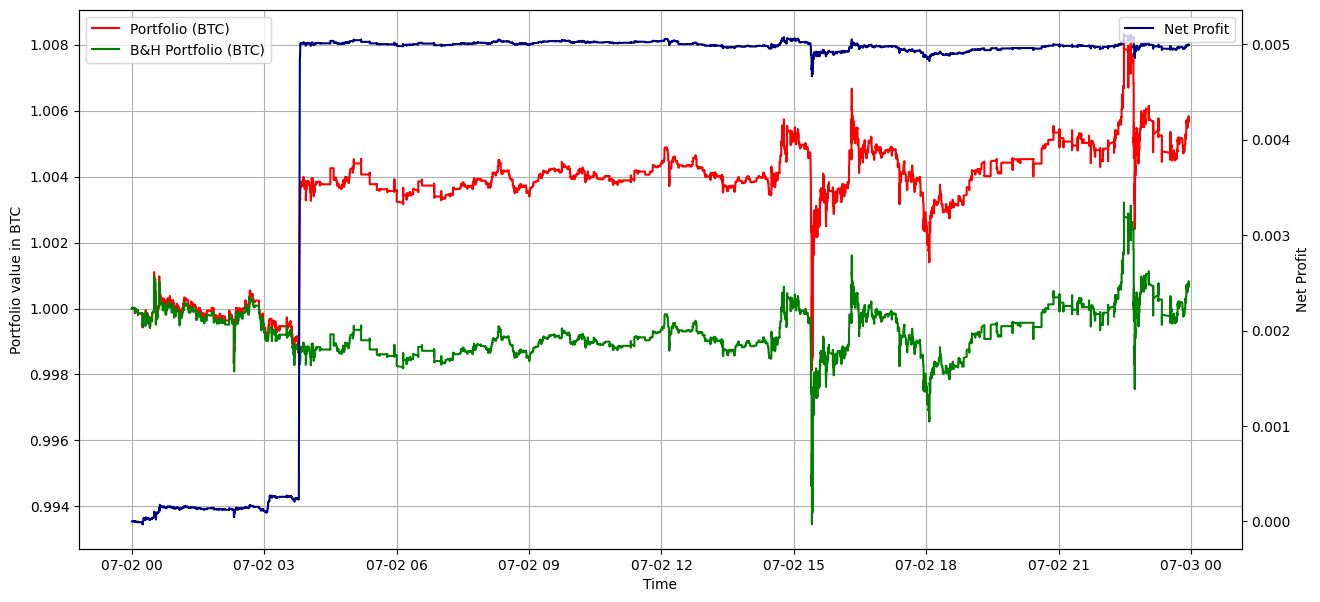

In [13]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.plot((1+(bal.combined_origin + bal.combined_hedging).pct_change()).cumprod(), label='Portfolio (BTC)', color='r')
ax.plot((1+(bal.bh_quote + bal.bh_base * bal.mid).pct_change()).cumprod(), label='B&H Portfolio (BTC)', color='g')

ax2 = ax.twinx()
ax2.plot((1+(bal.combined_origin + bal.combined_hedging).pct_change()).cumprod() - (1+(bal.bh_quote + bal.bh_base * bal.mid).pct_change()).cumprod(), label='Net Profit', color='navy')
#ax2.plot(bal.mid, label='COMPBTC Price')
ax.set_xlabel('Time')
ax2.set_ylabel('Net Profit')
ax.set_ylabel('Portfolio value in BTC')
ax.legend(loc=2)
ax2.legend(loc=1)
ax.grid()

## Trade Exploration

In [14]:
binance_data.set_index('timestamp', inplace=True)
upbit_data.set_index('timestamp', inplace=True)

In [15]:
start =int(datetime(2023, 7, 1, 0, 0).timestamp() * 1_000_000)
end = int(datetime(2023, 7, 1, 3, 0).timestamp() * 1_000_000)

In [16]:
o_trades = pd.DataFrame(origin.trades)
h_trades = pd.DataFrame(hedging.trades)
orders = pd.DataFrame(origin.orders)

In [17]:
for i in [o_trades, h_trades, orders]:
    if len(i) > 0:
        i['entryTime'] = pd.to_datetime(i['entryTime'], unit='us')
        i['eventTime'] = pd.to_datetime(i['eventTime'], unit='us')

In [18]:
binance_data.index = pd.to_datetime(binance_data.index, unit='us')
upbit_data.index = pd.to_datetime(upbit_data.index, unit='us')

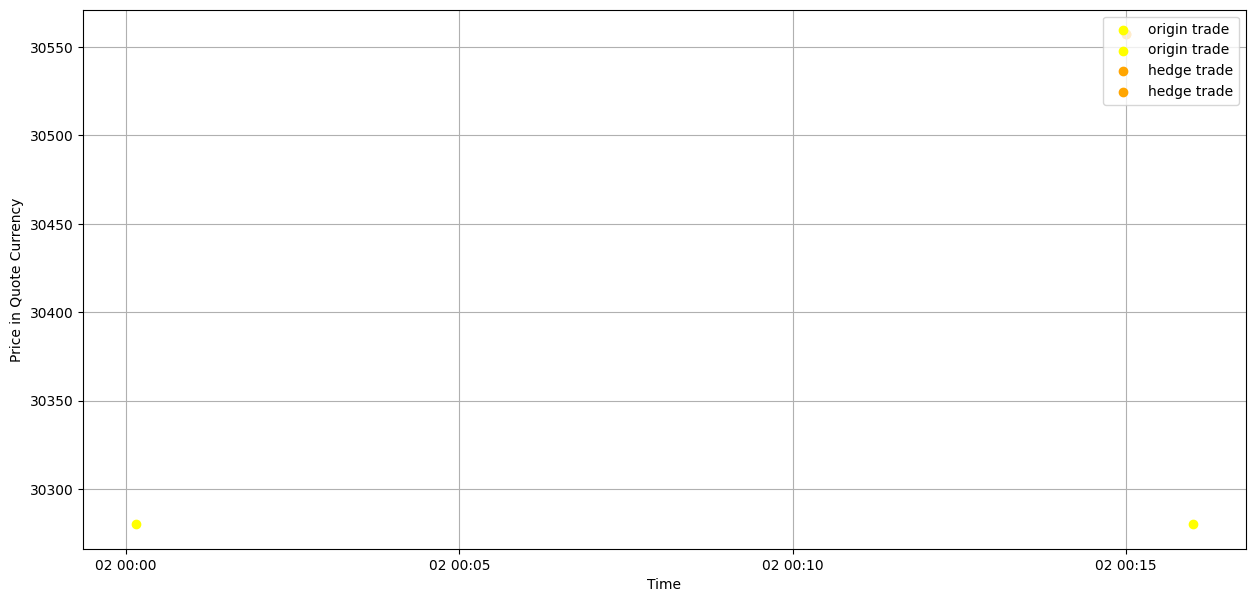

In [19]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.scatter(o_trades.entryTime[0], o_trades.price[0], color='yellow', label='origin trade')
ax.scatter(o_trades.eventTime[0], o_trades.price[0], color='yellow', label='origin trade')
ax.scatter(h_trades.entryTime[0], h_trades.price[0], color='orange', label='hedge trade')
ax.scatter(h_trades.eventTime[0], h_trades.price[0], color='orange', label='hedge trade')

ax.set_xlabel('Time')
ax.set_ylabel('Price in Quote Currency')
ax.legend(loc=1)
ax.grid()

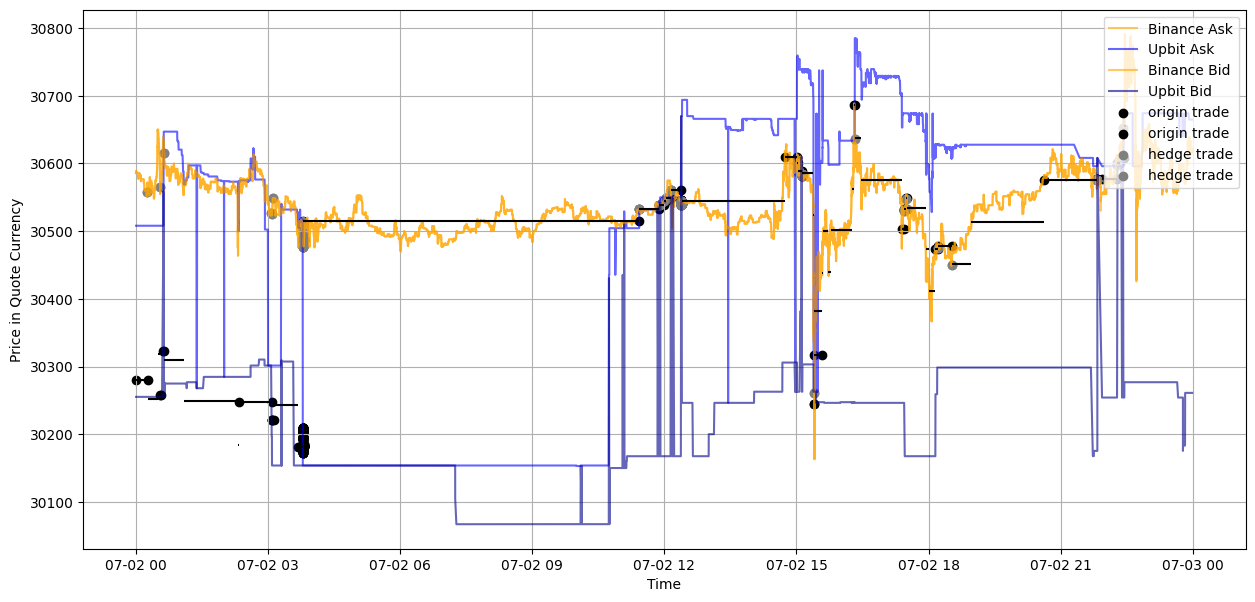

In [20]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.plot(binance_data['ask_price'], label='Binance Ask', color='orange', alpha=0.6)
ax.plot(upbit_data['ask_price'], label='Upbit Ask', color='blue', alpha=0.6)
ax.plot(binance_data['bid_price'], label='Binance Bid', color='orange', alpha=0.6)
ax.plot(upbit_data['bid_price'], label='Upbit Bid', color='darkblue', alpha=0.6)

ax.scatter(o_trades.entryTime, o_trades.price, color='black', label='origin trade')
ax.scatter(o_trades.eventTime, o_trades.price, color='black', label='origin trade')
ax.scatter(h_trades.entryTime, h_trades.price, color='grey', label='hedge trade')
ax.scatter(h_trades.eventTime, h_trades.price, color='grey', label='hedge trade')

ax.hlines(y=orders.price, xmin=orders.entryTime, xmax=orders.eventTime, colors='black', alpha=1, linestyles='solid')

ax.set_xlabel('Time')
ax.set_ylabel('Price in Quote Currency')
ax.legend(loc=1)
ax.grid()

In [21]:
trades = pd.concat([o_trades, h_trades])
trades['volume'] = trades.price * trades.amount
trades = trades.groupby('side')[['amount', 'volume']].sum()

In [22]:
trades['vwap'] = trades.volume / trades.amount

In [23]:
trades.vwap * trades.amount

side
0    53110.641812
1    52505.672940
dtype: float64

In [24]:
trades

,amount,volume,vwap
side,,,
0,1.74,53110.641812,30523.357363
1,1.73,52505.672940,30350.099965
